In [ ]:
from google.colab import drive
drive.mount('/content/gddrive')

Drive already mounted at /content/gddrive; to attempt to forcibly remount, call drive.mount("/content/gddrive", force_remount=True).


In [ ]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import cv2
import os
%matplotlib inline 

In [ ]:
base_directory='gddrive/MyDrive/dataset/input/chest-xray-pneumonia/'
train_pneumonia=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')
test_dir_normal=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/test/NORMAL/')

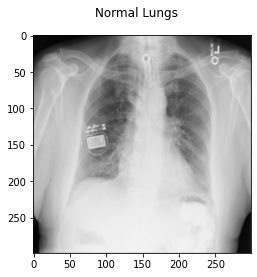

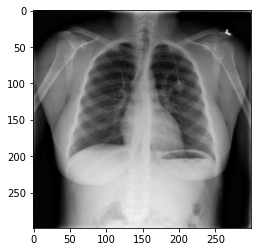

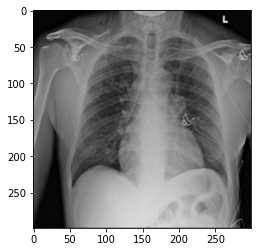

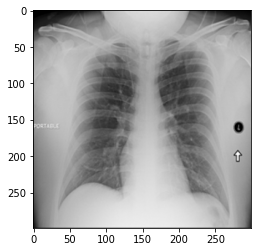

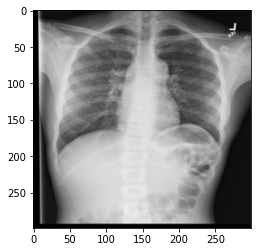

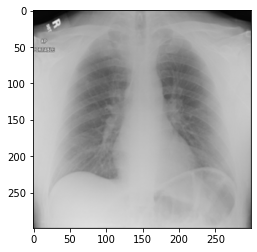

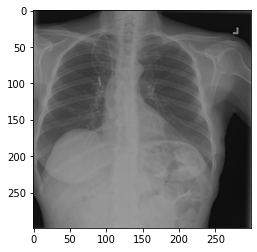

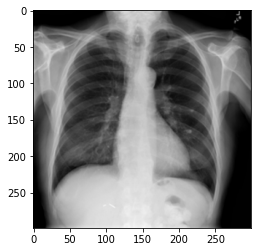

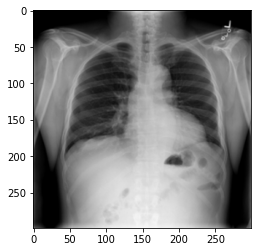

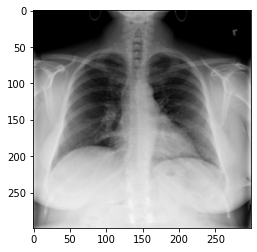

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
plt.suptitle('Normal Lungs')
for i in range(0,10):
    img = train_normal[i]
    img = load_img('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/train/NORMAL/' + img)
    plt.imshow(img)
    plt.show()

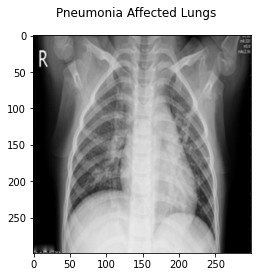

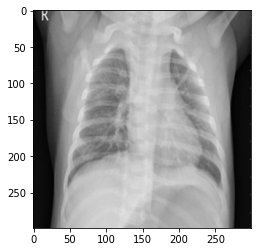

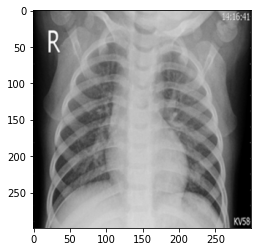

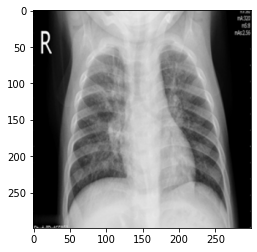

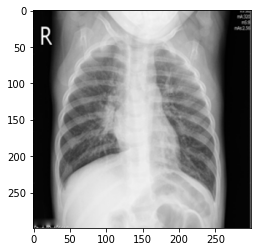

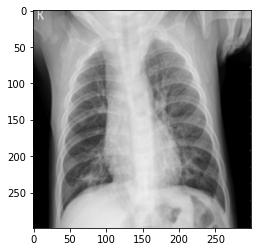

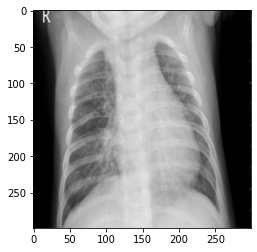

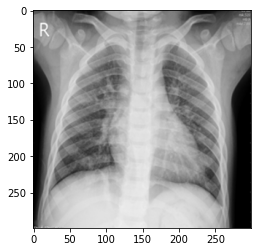

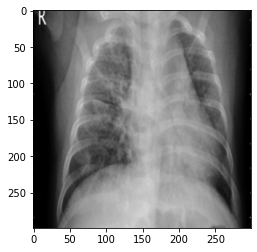

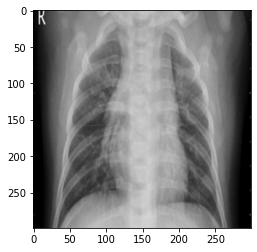

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
plt.suptitle('Pneumonia Affected Lungs')
for i in range(0,10):
    img = train_pneumonia[i]
    img = load_img('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/' + img)
    plt.imshow(img)
    plt.show()

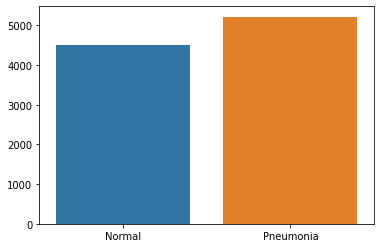

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(train_normal),len(train_pneumonia)])

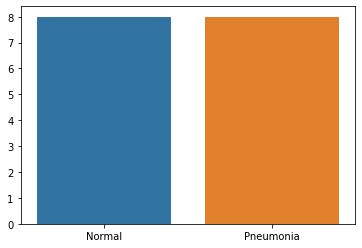

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(val_dir_normal),len(val_dir_pneumonia)])

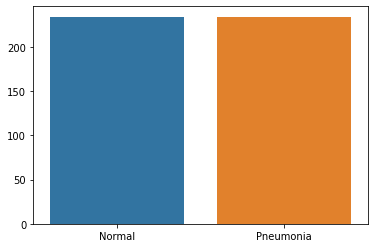

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(test_dir_normal),len(test_dir_pneumonia)])

In [ ]:
y_train_temp=[]
for i in range(len(train_normal)):
    y_train_temp.append(0)
for i in range(len(train_pneumonia)):
    y_train_temp.append(1)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=7,
    width_shift_range=0.5,
    height_shift_range=0.45,
    shear_range=0.2,
    zoom_range=0.45,
    horizontal_flip=True
    
)
test_datagen=ImageDataGenerator(
    rescale=1/255.0
)

In [ ]:
 train_set=train_datagen.flow_from_directory('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/train/',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 shuffle=True,
                                                 class_mode='binary')

Found 9729 images belonging to 2 classes.


In [ ]:
val_set=test_datagen.flow_from_directory('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/val/',
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='binary'
                                        )

Found 16 images belonging to 2 classes.


In [ ]:
test_set=test_datagen.flow_from_directory('gddrive/MyDrive/dataset/input/chest-xray-pneumonia/chest_xray/test/',
                                          target_size=(224,224),
                                          batch_size=1,
                                          class_mode='binary',
                                          shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(224,224,3),weights='imagenet')
#pretrain_model_path = '/content/drive/My Drive/v3.h5'
layer=inception.get_layer('mixed7')
#x.load_weights(pretrain_model_path)
x=tf.keras.layers.Flatten()(layer.output)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs=inception.input,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','mae'])

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
my_callback = MyThresholdCallback(threshold=0.93)
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
history = model.fit_generator(train_set,
                    epochs=30,
                    validation_data=test_set,
                    callbacks=[my_callback]
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
305/305 [==============================] - 3157s 10s/step - loss: 0.2344 - accuracy: 0.9159 - mae: 0.1136 - val_loss: 1.0783 - val_accuracy: 0.9119 - val_mae: 0.0885
Epoch 2/30
305/305 [==============================] - 214s 701ms/step - loss: 0.1235 - accuracy: 0.9565 - mae: 0.0623 - val_loss: 4.0303 - val_accuracy: 0.7628 - val_mae: 0.2372
Epoch 3/30
305/305 [==============================] - 214s 699ms/step - loss: 0.1172 - accuracy: 0.9614 - mae: 0.0569 - val_loss: 4.0734 - val_accuracy: 0.9199 - val_mae: 0.0806
Epoch 4/30
305/305 [==============================] - 214s 702ms/step - loss: 0.1005 - accuracy: 0.9654 - mae: 0.0518 - val_loss: 2.5010 - val_accuracy: 0.8798 - val_mae: 0.1281
Epoch 5/30
305/305 [==============================] - 214s 702ms/step - loss: 0.0978 - accuracy: 0.9708 - mae: 0.0448 - val_loss: 0.5999 - val_accuracy: 0.9327 - val_mae: 0.0683


In [ ]:
predict=model.evaluate(test_set)

624/624 [==============================] - 12s 20ms/step - loss: 0.5999 - accuracy: 0.9327 - mae: 0.0683


In [ ]:
model.save('model_new_data.h5')

In [ ]:
predicted=model.predict_generator(test_set,steps=624)
result=np.array(predicted>0.5,dtype='int32')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
x_test=test_set.classes
tester1=x_test.reshape((624,1))

In [ ]:
from sklearn.metrics import confusion_matrix
metrics=confusion_matrix(test_set.classes,result)
print(metrics)

[[208  26]
 [ 16 374]]


In [ ]:
from sklearn.metrics import auc,roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(x_test,predicted)
auc = roc_auc_score(x_test, predicted)

In [ ]:
print(auc)

0.9734001753232523
